In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.transform import radon , iradon
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM
from sklearn.metrics import f1_score
import cv2
np.random.seed(100)

In [2]:
#Loading the Datset
ctscan = scipy.io.loadmat(r"C:\Users\sayan\OneDrive\Desktop\Medical Image Assignments\HW1\ctscan_hw1.mat")
mask = scipy.io.loadmat(r"C:\Users\sayan\OneDrive\Desktop\Medical Image Assignments\HW1\infmsk_hw1.mat")
arr_scan = ctscan["ctscan"]
arr_msk = mask['infmsk']

## Q1

In [3]:
#Distribution of the Dataset
h_map = {"Normal" : 0 , "Mild" : 0 , "Severe" : 0}
label_N = []
label_M = []
label_S  = []

def infection(sample):
    rate = 100*np.sum(sample ==1) /(np.sum(sample!=0))
    return rate

for sample in range(arr_msk.shape[2]):
    if infection(arr_msk[:,:,sample])==0:
        h_map['Normal'] += 1
        label_N.append(sample)
    elif 40>= infection(arr_msk[:,:,sample]) > 0:
        h_map['Mild'] +=1
        label_M.append(sample)
    elif infection(arr_msk[:,:,sample])>40:
        h_map['Severe'] += 1
        label_S.append(sample)
print('DATASET distribution is as follows \n')
print('Normal={} ; {} % of the dataset'.format(h_map['Normal'],(h_map['Normal']/arr_msk.shape[2])*100))
print('Mild={} ; {} % of the dataset'.format(h_map['Mild'],(h_map['Mild']/arr_msk.shape[2])*100))
print('Severe={} ; {} % of the dataset'.format(h_map['Severe'],(h_map['Severe']/arr_msk.shape[2])*100))

DATASET distribution is as follows 

Normal=1441 ; 40.545863815419246 % of the dataset
Mild=1954 ; 54.98030388294879 % of the dataset
Severe=159 ; 4.473832301631964 % of the dataset


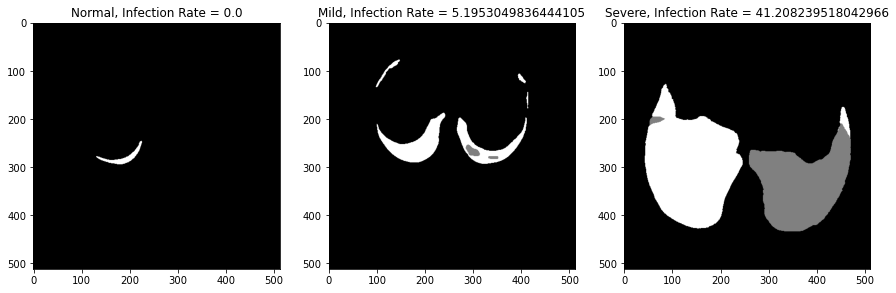

In [4]:
#Viewing one sample of each class
view_sample = np.random.randint(0, high=min(len(label_N),len(label_M),len(label_S)))
figure_size = 15
fig,ax = plt.subplots(1,3,figsize=(figure_size,figure_size))
ax[0].set_title('Normal, Infection Rate = {}'.format(infection(arr_msk[:,:,label_N[view_sample]])))#, plt.xticks([]), plt.yticks([])
ax[0].imshow(arr_msk[:,:,label_N[view_sample]] ,cmap='gray')
ax[1].set_title('Mild, Infection Rate = {}'.format(infection(arr_msk[:,:,label_M[view_sample]])))
ax[1].imshow(arr_msk[:,:,label_M[view_sample]] ,cmap='gray')
ax[2].set_title('Severe, Infection Rate = {}'.format(infection(arr_msk[:,:,label_S[view_sample]])))
ax[2].imshow(arr_msk[:,:,label_S[view_sample]] ,cmap='gray')
plt.show()

In [5]:
#Auxiliary Function 1
def revert_img(img):
    new_img=np.zeros(img.shape)
    unique,counts = np.unique(img,return_counts=True)
    counts = counts.tolist()
    if len(np.unique(counts)) == 2:
        counts[-1] -= 1

    back = unique[counts.index(max(counts))]
    abnormal = unique[counts.index(min(counts))]
    normal = list(set(unique)-set([back,abnormal]))
    
    new_img[img==back] = 0
    new_img[img==normal] = 2
    new_img[img==abnormal] = 1
    
    return new_img

In [6]:
#Auxiliary Function 2
def KMeans_routine(scan_given):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 3
    flags = cv2.KMEANS_RANDOM_CENTERS
    arr_flat = np.float32(np.reshape(mask_given,[-1,1]))
    ret,label,center = cv2.kmeans(arr_flat,K,None,criteria,attempts,flags)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((mask_given.shape))
    return result_image
    

In [7]:
def Spec_Sens_acc_f1_INF(mask_given,mask_made):
    
    TP=np.sum((mask_made==1)  * (mask_given==mask_made))
    TN = np.sum((mask_made==2) * (mask_given==mask_made)) + np.sum((mask_made==0) * (mask_given==mask_made))
    FP = np.sum((mask_made==1) * (mask_given==2)) + np.sum((mask_made==1) * (mask_given==0))
    FN = np.sum((mask_made==2) * (mask_given==1)) + np.sum((mask_made==0) * (mask_given==1))
    acc=(TP+TN)/(TP+TN+FP+FN)
    spec=TN / (TN + FP)
    sens=TP / (TP + FN) 
    
    
    prec = TP/(TP+FP)
    recall = TP/(TP+FN)
    
    
    f1 = 2*prec*recall/(prec+recall)
    if TP==0:
        sens = 0
        prec = 0
        recall = 0
        f1 = 0
  
    return f1,acc,spec,sens

def Spec_Sens_acc_f1_Nor(mask_given,mask_made):
    
    TP=np.sum((mask_made==2)  * (mask_given==mask_made))
    TN = np.sum((mask_made==1) * (mask_given==mask_made)) + np.sum((mask_made==0) * (mask_given==mask_made))
    
    FP = np.sum((mask_made==2) * (mask_given==1)) + np.sum((mask_made==2) * (mask_given==0))
    FN = np.sum((mask_made==1) * (mask_given==2)) + np.sum((mask_made==0) * (mask_given==2))
    
    acc=(TP+TN)/(TP+TN+FP+FN)
    spec=TN / (TN + FP)
    sens=TP / (TP + FN) 
    
    
    prec = TP/(TP+FP)
    recall = TP/(TP+FN)
    
    
    f1 = 2*prec*recall/(prec+recall)
    if TP==0:
        sens = 0
        prec = 0
        recall = 0
        f1 = 0
    return f1,acc,spec,sens


## Q2

In [8]:
#Finding the averaged Dice Score, Accuracy, Sensitivity, Specificity of the predicted masks from KMeans
#For Infected Regions
DICE=[]
SPEC = []
SENS=[]
ACC=[]
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
flags = cv2.KMEANS_RANDOM_CENTERS

attempts=10
for i in range(arr_scan.shape[2]):    
    result_image = KMeans_routine(arr_scan[:,:,i])
    reverted = revert_img(result_image)
    
    f1,acc,spec,sens = Spec_Sens_acc_f1_INF(arr_msk[:,:,i],reverted)
    DICE.append(f1)
    SPEC.append(spec)
    SENS.append(sens)
    ACC.append(acc)
    
    
avg_f1=np.mean(DICE)
avg_spec=np.mean(SPEC)
avg_sens=np.mean(SENS)
avg_acc=np.mean(ACC)

print(f'Dice Score={avg_f1} \nSPEC={avg_spec} \nSENS={avg_sens} \nACCURACY={avg_acc} FOR INFECTED REGIONS')

C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/1105428955.py:9: RuntimeWarning: invalid value encountered in long_scalars
  sens=TP / (TP + FN)
C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/1105428955.py:13: RuntimeWarning: invalid value encountered in long_scalars
  recall = TP/(TP+FN)
C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/1105428955.py:16: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*prec*recall/(prec+recall)


Dice Score=0.18124914622768143 
SPEC=0.9792756491766664 
SENS=0.28642228747752707 
ACCURACY=0.9736182241679764 FOR INFECTED REGIONS


In [9]:
#Finding the averaged Dice Score, Accuracy, Sensitivity, Specificity of the predicted masks from KMeans
#For Normal Regions
DICE=[]
SPEC = []
SENS=[]
ACC=[]
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
flags = cv2.KMEANS_RANDOM_CENTERS

attempts=10
for i in range(arr_scan.shape[2]):    
    result_image = KMeans_routine(arr_scan[:,:,i])
    reverted = revert_img(result_image)
    
    f1,acc,spec,sens = Spec_Sens_acc_f1_Nor(arr_msk[:,:,i],reverted)

    DICE.append(f1)
    SPEC.append(spec)
    SENS.append(sens)
    ACC.append(acc)
    
    
avg_f1=np.mean(DICE)
avg_spec=np.mean(SPEC)
avg_sens=np.mean(SENS)
avg_acc=np.mean(ACC)

print(f'Dice Score={avg_f1} \nSPEC={avg_spec} \nSENS={avg_sens} \nACCURACY={avg_acc} FOR NORMAL REGIONS')

Dice Score=0.8617058608291494 
SPEC=0.9955985206803886 
SENS=0.7975969692578291 
ACCURACY=0.9718789430673432 FOR NORMAL REGIONS


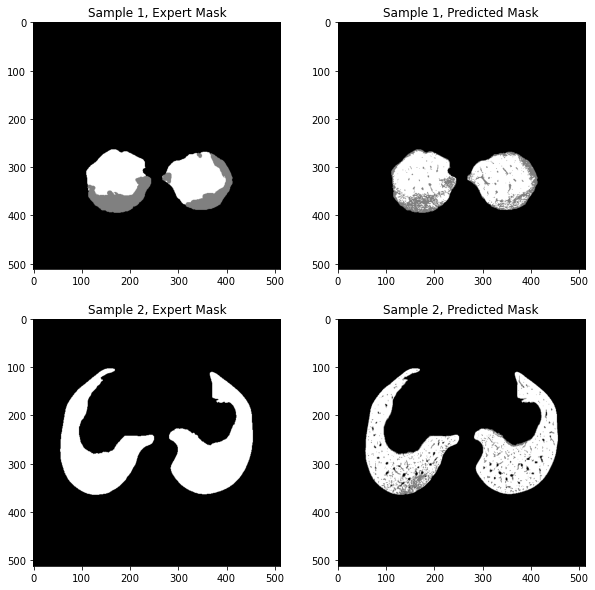

In [10]:
#Display two sample slices along with the expert infection mask and predicted mask.

sample1 = np.random.randint(0, high=arr_msk.shape[2])
sample2 = np.random.randint(0, high=arr_msk.shape[2])
result_image = KMeans_routine(arr_scan[:,:,sample1])
reverted1 = revert_img(result_image)
result_image = KMeans_routine(arr_scan[:,:,sample2])
reverted2 = revert_img(result_image)

figure_size = 10
fig,ax = plt.subplots(2,2,figsize=(figure_size,figure_size))
ax[0,0].set_title('Sample 1, Expert Mask')
ax[0,0].imshow(arr_msk[:,:,sample1] ,cmap='gray')
ax[0,1].set_title('Sample 1, Predicted Mask')
ax[0,1].imshow(reverted1 ,cmap='gray')
ax[1,0].set_title('Sample 2, Expert Mask')
ax[1,0].imshow(arr_msk[:,:,sample2] ,cmap='gray')
ax[1,1].set_title('Sample 2, Predicted Mask')
ax[1,1].imshow(reverted2 ,cmap='gray')
plt.show()

## Q3

In [11]:
#Finding the averaged PSNR and SSIM for reconstructed CT scans from limited angles(4x)
#Finding the Dice Score, Accuracy, Sensitivity, Specificity of the predicted masks by applying KMeans on reconstructed CT scans
#For Normal Regions
theta = np.arange(0,181,4)
PSNRs=[]
SSIMs=[]
DICE=[]
SPEC = []
SENS=[]
ACC=[]
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
flags = cv2.KMEANS_RANDOM_CENTERS
for i in range(arr_msk.shape[2]):
    image = arr_scan[:,:,i].astype(np.float64)
    sinogram = radon(image, theta=theta,circle = False)
    reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='hann',circle = False, output_size=512)
    PSNRs.append(PSNR(image, reconstruction_fbp,data_range = image.max()-image.min()))
    SSIMs.append(SSIM(image, reconstruction_fbp,data_range = image.max()-image.min()))

    result_image = KMeans_routine(reconstruction_fbp)
    reverted = revert_img(result_image)   
    f1,acc,spec,sens = Spec_Sens_acc_f1_Nor(arr_msk[:,:,i],reverted)
    
    DICE.append(f1)
    SPEC.append(spec)
    SENS.append(sens)
    ACC.append(acc)
    
    
avg_f1=np.mean(DICE)
avg_spec=np.mean(SPEC)
avg_sens=np.mean(SENS)
avg_acc=np.mean(ACC)        
avg_PSNR = np.mean(PSNRs)
avg_SSIM = np.mean(SSIMs)

print(f'Dice Score={avg_f1} \nSPEC={avg_spec} \nSENS={avg_sens} \nACCURACY={avg_acc} \nPSNR={avg_PSNR} \nSSIM={avg_SSIM} FOR NORMAL REGIONS at 4x resolution')    

C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/1105428955.py:42: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*prec*recall/(prec+recall)
C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/3459456243.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  new_img[img==normal] = 2
C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/1105428955.py:38: RuntimeWarning: invalid value encountered in long_scalars
  prec = TP/(TP+FP)


Dice Score=0.7103903277168012 
SPEC=0.9191570435302434 
SENS=0.7538211158183519 
ACCURACY=0.9039726922535495 
PSNR=16.099146774586174 
SSIM=0.3324795053526668 FOR NORMAL REGIONS at 4x resolution


In [12]:
#Finding the averaged PSNR and SSIM for reconstructed CT scans from limited angles(4x)
#Finding the Dice Score, Accuracy, Sensitivity, Specificity of the predicted masks by applying KMeans on reconstructed CT scans
#For Infected Regions
theta = np.arange(0,181,4)
PSNRs=[]
SSIMs=[]
DICE=[]
SPEC = []
SENS=[]
ACC=[]
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
flags = cv2.KMEANS_RANDOM_CENTERS
for i in range(arr_scan.shape[2]):
    image = arr_scan[:,:,i].astype(np.float64)
    sinogram = radon(image, theta=theta,circle = False)
    reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='hann',circle = False, output_size=512)
    PSNRs.append(PSNR(image, reconstruction_fbp,data_range = image.max()-image.min()))
    SSIMs.append(SSIM(image, reconstruction_fbp,data_range = image.max()-image.min()))

    result_image = KMeans_routine(reconstruction_fbp)
    reverted = revert_img(result_image)   
    f1,acc,spec,sens = Spec_Sens_acc_f1_INF(arr_msk[:,:,i],reverted)
    
    DICE.append(f1)
    SPEC.append(spec)
    SENS.append(sens)
    ACC.append(acc)
    
    
avg_f1=np.mean(DICE)
avg_spec=np.mean(SPEC)
avg_sens=np.mean(SENS)
avg_acc=np.mean(ACC)        
avg_PSNR = np.mean(PSNRs)
avg_SSIM = np.mean(SSIMs)

print(f'F1={avg_f1} \nSPEC={avg_spec} \nSENS={avg_sens} \nACCURACY={avg_acc} \nPSNR={avg_PSNR} \nSSIM={avg_SSIM} FOR INFECTED REGIONS at 4x resolution')    

C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/1105428955.py:9: RuntimeWarning: invalid value encountered in long_scalars
  sens=TP / (TP + FN)
C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/1105428955.py:13: RuntimeWarning: invalid value encountered in long_scalars
  recall = TP/(TP+FN)
C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/1105428955.py:16: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*prec*recall/(prec+recall)
C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/3459456243.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  new_img[img==normal] = 2


F1=0.04957929607116206 
SPEC=0.9589606964504156 
SENS=0.1020566662608242 
ACCURACY=0.9512847981762426 
PSNR=16.099146774586174 
SSIM=0.3324795053526668 FOR INFECTED REGIONS at 4x resolution


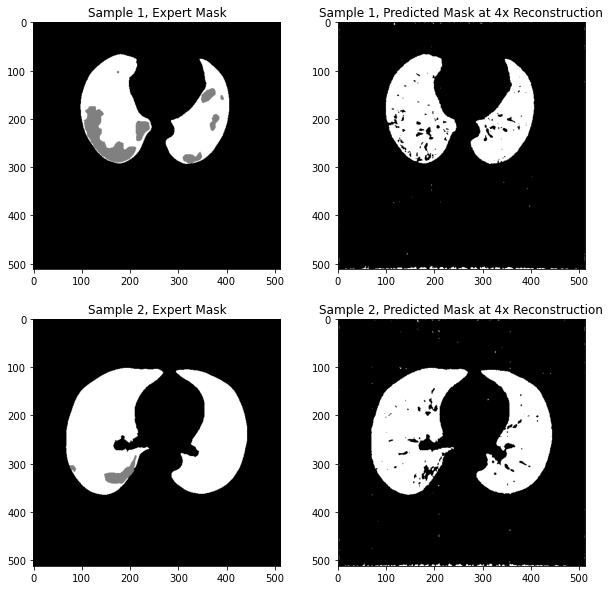

In [13]:
#Display two sample slices along with the expert infection mask and predicted mask obtained from 4x reconstruction.
theta = np.arange(0,181,4)
sample1 = np.random.randint(0, high=arr_msk.shape[2])
sample2 = np.random.randint(0, high=arr_msk.shape[2])
image1 = arr_scan[:,:,sample1].astype(np.float64)
image2 = arr_scan[:,:,sample2].astype(np.float64)

sinogram = radon(image1, theta=theta,circle = False)
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='hann',circle = False, output_size=512)
result_image = KMeans_routine(reconstruction_fbp)
reverted1 = revert_img(result_image)

sinogram = radon(image2, theta=theta,circle = False)
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='hann',circle = False, output_size=512)
result_image = KMeans_routine(reconstruction_fbp)
reverted2 = revert_img(result_image)

figure_size = 10
fig,ax = plt.subplots(2,2,figsize=(figure_size,figure_size))
ax[0,0].set_title('Sample 1, Expert Mask')
ax[0,0].imshow(arr_msk[:,:,sample1] ,cmap='gray')
ax[0,1].set_title('Sample 1, Predicted Mask at 4x Reconstruction')
ax[0,1].imshow(reverted1 ,cmap='gray')
ax[1,0].set_title('Sample 2, Expert Mask')
ax[1,0].imshow(arr_msk[:,:,sample2] ,cmap='gray')
ax[1,1].set_title('Sample 2, Predicted Mask at 4x Reconstruction')
ax[1,1].imshow(reverted2 ,cmap='gray')
plt.show()

In [14]:
#Finding the averaged PSNR and SSIM for reconstructed CT scans from limited angles(8x)
#Finding the Dice Score, Accuracy, Sensitivity, Specificity of the predicted masks by applying KMeans on reconstructed CT scans
#For Normal Regions
theta = np.arange(0,181,8)
PSNRs=[]
SSIMs=[]
DICE=[]
SPEC = []
SENS=[]
ACC=[]
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
flags = cv2.KMEANS_RANDOM_CENTERS
for i in range(arr_msk.shape[2]):
    image = arr_scan[:,:,i].astype(np.float64)
    sinogram = radon(image, theta=theta,circle = False)
    reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='hann',circle = False, output_size=512)
    PSNRs.append(PSNR(image, reconstruction_fbp,data_range = image.max()-image.min()))
    SSIMs.append(SSIM(image, reconstruction_fbp,data_range = image.max()-image.min()))

    result_image = KMeans_routine(reconstruction_fbp)
    reverted = revert_img(result_image)   
    f1,acc,spec,sens = Spec_Sens_acc_f1_Nor(arr_msk[:,:,i],reverted)
    
    DICE.append(f1)
    SPEC.append(spec)
    SENS.append(sens)
    ACC.append(acc)
    
    
avg_f1=np.mean(DICE)
avg_spec=np.mean(SPEC)
avg_sens=np.mean(SENS)
avg_acc=np.mean(ACC)        
avg_PSNR = np.mean(PSNRs)
avg_SSIM = np.mean(SSIMs)

print(f'F1={avg_f1} \nSPEC={avg_spec} \nSENS={avg_sens} \nACCURACY={avg_acc} \nPSNR={avg_PSNR} \nSSIM={avg_SSIM} FOR NORMAL REGIONS at 8x resolution')    

C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/1105428955.py:42: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*prec*recall/(prec+recall)
C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/3459456243.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  new_img[img==normal] = 2
C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/1105428955.py:38: RuntimeWarning: invalid value encountered in long_scalars
  prec = TP/(TP+FP)


F1=0.6344326500524781 
SPEC=0.879002930248171 
SENS=0.7405864675914866 
ACCURACY=0.8658083762550931 
PSNR=14.668666813634943 
SSIM=0.22399899533532497 FOR NORMAL REGIONS at 8x resolution


In [15]:
#Finding the averaged PSNR and SSIM for reconstructed CT scans from limited angles(8x)
#Finding the Dice Score, Accuracy, Sensitivity, Specificity of the predicted masks by applying KMeans on reconstructed CT scans
#For Infected Regions
theta = np.arange(0,181,8)
PSNRs=[]
SSIMs=[]
DICE=[]
SPEC = []
SENS=[]
ACC=[]
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
flags = cv2.KMEANS_RANDOM_CENTERS
for i in range(arr_scan.shape[2]):
    image = arr_scan[:,:,i].astype(np.float64)
    sinogram = radon(image, theta=theta,circle = False)
    reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='hann',circle = False, output_size=512)
    PSNRs.append(PSNR(image, reconstruction_fbp,data_range = image.max()-image.min()))
    SSIMs.append(SSIM(image, reconstruction_fbp,data_range = image.max()-image.min()))

    result_image = KMeans_routine(reconstruction_fbp)
    reverted = revert_img(result_image)   
    f1,acc,spec,sens = Spec_Sens_acc_f1_INF(arr_msk[:,:,i],reverted)
    
    DICE.append(f1)
    SPEC.append(spec)
    SENS.append(sens)
    ACC.append(acc)
    
    
avg_f1=np.mean(DICE)
avg_spec=np.mean(SPEC)
avg_sens=np.mean(SENS)
avg_acc=np.mean(ACC)        
avg_PSNR = np.mean(PSNRs)
avg_SSIM = np.mean(SSIMs)

print(f'F1={avg_f1} \nSPEC={avg_spec} \nSENS={avg_sens} \nACCURACY={avg_acc} \nPSNR={avg_PSNR} \nSSIM={avg_SSIM} FOR INFECTED REGIONS at 8x resolution')    

C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/1105428955.py:9: RuntimeWarning: invalid value encountered in long_scalars
  sens=TP / (TP + FN)
C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/1105428955.py:13: RuntimeWarning: invalid value encountered in long_scalars
  recall = TP/(TP+FN)
C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/1105428955.py:16: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*prec*recall/(prec+recall)
C:\Users\sayan\AppData\Local\Temp/ipykernel_14680/3459456243.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  new_img[img==normal] = 2


F1=0.03490949077686466 
SPEC=0.9518939607555132 
SENS=0.10569136992628457 
ACCURACY=0.9443596893601672 
PSNR=14.668666813634943 
SSIM=0.22399899533532497 FOR INFECTED REGIONS at 8x resolution


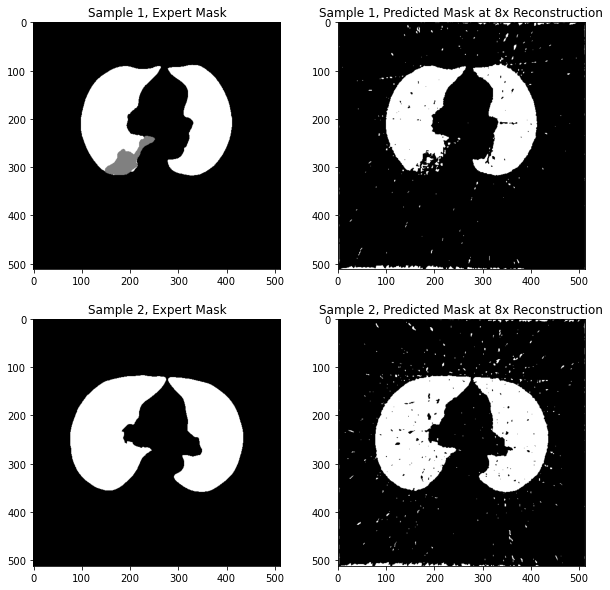

In [16]:
#Display two sample slices along with the expert infection mask and predicted mask obtained from 4x reconstruction.
theta = np.arange(0,181,8)
sample1 = np.random.randint(0, high=arr_msk.shape[2])
sample2 = np.random.randint(0, high=arr_msk.shape[2])
image1 = arr_scan[:,:,sample1].astype(np.float64)
image2 = arr_scan[:,:,sample2].astype(np.float64)

sinogram = radon(image1, theta=theta,circle = False)
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='hann',circle = False, output_size=512)
result_image = KMeans_routine(reconstruction_fbp)
reverted1 = revert_img(result_image)

sinogram = radon(image2, theta=theta,circle = False)
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='hann',circle = False, output_size=512)
result_image = KMeans_routine(reconstruction_fbp)
reverted2 = revert_img(result_image)

figure_size = 10
fig,ax = plt.subplots(2,2,figsize=(figure_size,figure_size))
ax[0,0].set_title('Sample 1, Expert Mask')
ax[0,0].imshow(arr_msk[:,:,sample1] ,cmap='gray')
ax[0,1].set_title('Sample 1, Predicted Mask at 8x Reconstruction')
ax[0,1].imshow(reverted1 ,cmap='gray')
ax[1,0].set_title('Sample 2, Expert Mask')
ax[1,0].imshow(arr_msk[:,:,sample2] ,cmap='gray')
ax[1,1].set_title('Sample 2, Predicted Mask at 8x Reconstruction')
ax[1,1].imshow(reverted2 ,cmap='gray')
plt.show()

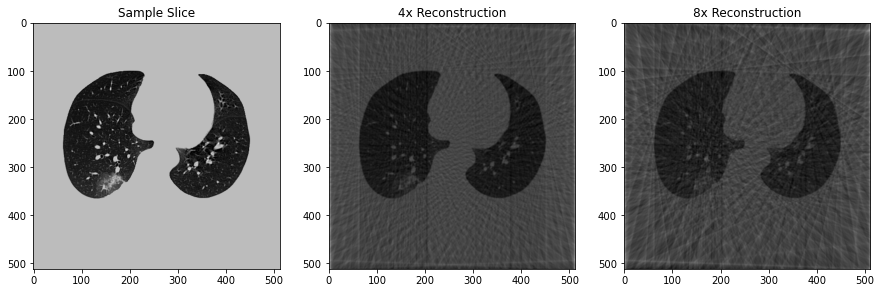

In [17]:
#Sample Slice with 4x reconstruction and 8x reconstruction
theta4 = np.arange(0,181,4)
theta8 = np.arange(0,181,8)
samplex = np.random.randint(0, high=arr_msk.shape[2])
imagex = arr_scan[:,:,samplex].astype(np.float64)

sinogram4 = radon(imagex, theta=theta4,circle = False)
reconstruction_fbp4 = iradon(sinogram4, theta=theta4, filter_name='hann',circle = False, output_size=512)

sinogram8 = radon(imagex, theta=theta8,circle = False)
reconstruction_fbp8 = iradon(sinogram8, theta=theta8, filter_name='hann',circle = False, output_size=512)

figure_size = 15
fig,ax = plt.subplots(1,3,figsize=(figure_size,figure_size))
ax[0].set_title('Sample Slice')
ax[0].imshow(arr_scan[:,:,samplex] ,cmap='gray')
ax[1].set_title('4x Reconstruction')
ax[1].imshow(reconstruction_fbp4 ,cmap='gray')
ax[2].set_title('8x Reconstruction')
ax[2].imshow(reconstruction_fbp8 ,cmap='gray')

plt.show()

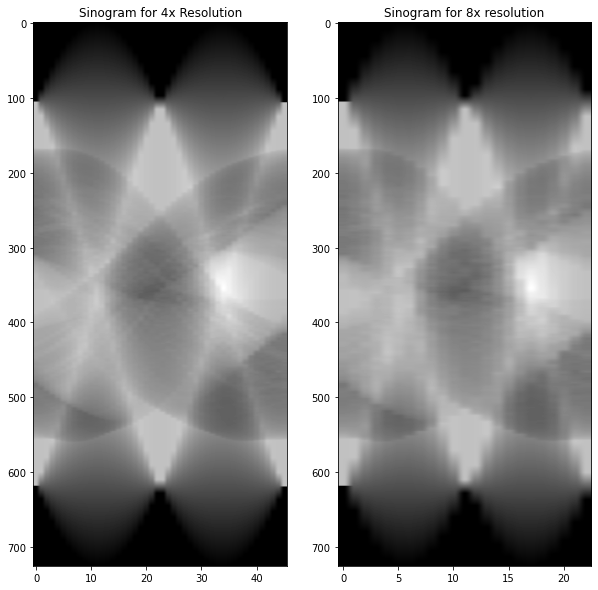

In [18]:
figure_size = 10
fig,ax = plt.subplots(1,2,figsize=(figure_size,figure_size))
ax[0].set_title('Sinogram for 4x Resolution')
ax[0].imshow(sinogram4 ,cmap='gray',aspect = 'auto')
ax[1].set_title('Sinogram for 8x resolution')
ax[1].imshow(sinogram8 ,cmap='gray',aspect = 'auto')